In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar  7 16:11:29 2024

@author: Peter Grant
"""

# Could do this differently. We don't need to know pumped gallons. Only revolutions of the motor
# Can do analysis based on solely on completing a certain number of revolutions
# Notes from EPRI/NREL report: (Use these notes to update algorithm)
    # - Shed reduces rpm to 1/3 of default speed
    # - Load up increases to maximum, which is set by the user. Default max is 3000 rpm. Can be adjusted as high as 3450 rpm

import os
import sys
import pandas as pd

# reference: https://www.pentair.com/content/dam/extranet/nam/pentair-pool/residential/pumps/archive/intelliflo-vsf/intelliflo-vsf-om-eng.pdf
modes = {
         'Speed1': {
                    'RPM': 750
                   },
         'Speed2': {
                    'RPM': 1500
                   },
         'Speed3': {
                    'RPM': 2350
                   },
         'Speed4': {
                    'RPM': 3110,
                   },
         'Max': {
                 'RPM': 3450
                }
    }

mode_map = {
            'Normal': 'Speed3',
            'LU': 'Speed4',
            'ALU': 'Max',
            'Shed': 'Speed2'
           }

# reference: https://engineeringlibrary.org/reference/centrifugal-pumps-fluid-flow-doe-handbook#:~:text=These%20laws%20state%20that%20the,cube%20of%20the%20pump%20speed.
# volumetric_flowrate is proportional to rpm
# pump power is proportional to rpm^3

# reference: https://www.pentair.com/content/dam/extranet/nam/pentair-pool/residential/pumps/archive/intelliflo-vsf/intelliflo-vsf-om-eng.pdf
max_power = 3.2 # kW
# min_flow = 30 # gal/min
max_flow = 80 # gal/min
# slope = (max_flow - min_flow) / (modes['Max']['RPM'] - modes['Speed1']['RPM'])
# intercept = min_flow - modes['Speed1']['RPM'] * slope

# assuming that min flow = speed1, max flow = max rpm
# Would need to verify this assumption with Pentair for field deployment, but good enough for now

for mode in modes.keys():
    modes[mode]['flow (gal/min)'] = max_flow * modes[mode]['RPM'] / modes['Max']['RPM'] #slope * modes[mode]['RPM'] + intercept
    modes[mode]['power (kW)'] = max_power * (modes[mode]['RPM']/modes['Max']['RPM'])**3  #modes[mode]['RPM'] / modes['Max']['RPM'] * max_power

print(modes)

{'Speed1': {'RPM': 750, 'flow (gal/min)': 17.391304347826086, 'power (kW)': 0.03287581162159941}, 'Speed2': {'RPM': 1500, 'flow (gal/min)': 34.78260869565217, 'power (kW)': 0.26300649297279527}, 'Speed3': {'RPM': 2350, 'flow (gal/min)': 54.492753623188406, 'power (kW)': 1.0113378933301678}, 'Speed4': {'RPM': 3110, 'flow (gal/min)': 72.1159420289855, 'power (kW)': 2.344087722406388}, 'Max': {'RPM': 3450, 'flow (gal/min)': 80.0, 'power (kW)': 3.2}}


In [2]:

# assume occpants want low noise, low flow rates overnight
low_flow_hours = [0, 1, 2, 3, 4, 5, 6, 22, 23]

# read prices
price_structure = 'TwoPeakHDP'
prices = pd.read_csv('CFH_Prices.csv', index_col = 0).loc[0:23, price_structure]
print(list(prices))

[0.1714, 0.144, 0.1385, 0.1518, 0.1829, 0.2713, 0.4659, 0.5328, 0.28, 0.1158, 0.0398, 0.0196, 0.011, 0.0188, 0.0255, 0.0632, 0.0957, 0.2358, 0.4931, 0.6618, 0.5364, 0.4116, 0.2905, 0.2209]


In [3]:

# creating baseline
# assumptions based on https://efficiencymb.ca/articles/programming-your-variable-speed-pool-pump/#:~:text=Scheduling%20your%20pump%20to%20run,1%2C500%20RPM%20and%202%2C000%20RPM.&text=You'll%20want%20to%20run,to%20four%20hours%20every%20day.
# assuming 3 hrs of high speed (Speed4), 20 hours of low speed (Speed2)
# assuming high speed in the middle of the day when people will be less irritated by noise
baseline_operation = pd.DataFrame(index = prices.index, columns = ['Mode', 'Flow (gal)', 'Power (kW)', 'Cost ($)'])
baseline_operation['Flow (gal)'] = float(0)
baseline_operation['Power (kW)'] = float(0)
baseline_operation['Cost ($)'] = float(0)
for hr in baseline_operation.index:
    if hr == 0 or hr == 1 or hr == 2 or hr == 3 or hr == 4 or hr == 5 or hr == 6 or hr == 7 or hr == 21 or hr == 22 or hr == 23:
        baseline_operation.loc[hr, 'Mode'] = 'Off'
        continue
    elif hr == 8 or hr == 9 or hr == 10:
        baseline_operation.loc[hr, 'Mode'] = 'LU'
    else:
        baseline_operation.loc[hr, 'Mode'] = 'Normal'
    
    # cost = prices.loc[hr] * modes['Speed3']['power (kW)']
    # baseline_operation.loc[hr, 'Mode'] = 'Normal'
    baseline_operation.loc[hr, 'Flow (gal)'] = modes[mode_map[baseline_operation.loc[hr, 'Mode']]]['flow (gal/min)'] * 60
    baseline_operation.loc[hr, 'Power (kW)'] = modes[mode_map[baseline_operation.loc[hr, 'Mode']]]['power (kW)']
    baseline_operation.loc[hr, 'Cost ($)'] = baseline_operation.loc[hr, 'Power (kW)'] * prices.loc[hr]

display(baseline_operation)
print(f"\nThe total flow is: {round(sum(baseline_operation['Flow (gal)']),2)} gal")

,Mode,Flow (gal),Power (kW),Cost ($)
0,Off,0.000000,0.000000,0.000000
1,Off,0.000000,0.000000,0.000000
2,Off,0.000000,0.000000,0.000000
3,Off,0.000000,0.000000,0.000000
4,Off,0.000000,0.000000,0.000000
5,Off,0.000000,0.000000,0.000000
6,Off,0.000000,0.000000,0.000000
7,Off,0.000000,0.000000,0.000000
8,LU,4326.956522,2.344088,0.656345
9,LU,4326.956522,2.344088,0.271445



The total flow is: 45676.52 gal


In [4]:

# Creating dataframe of all operation options
operation = pd.DataFrame(index = prices.index)
operation['Normal'] = prices * modes[mode_map['Normal']]['power (kW)'] / modes[mode_map['Normal']]['flow (gal/min)']
operation['LU'] = prices * modes[mode_map['LU']]['power (kW)'] / modes[mode_map['Normal']]['flow (gal/min)']
operation['ALU'] = prices * modes[mode_map['ALU']]['power (kW)' ] / modes[mode_map['Normal']]['flow (gal/min)']
operation['Shed'] = prices * modes[mode_map['Shed']]['power (kW)'] / modes[mode_map['Normal']]['flow (gal/min)']
display(operation)

,Normal,LU,ALU,Shed
0,0.003181,0.007373,0.010065,0.000827
1,0.002673,0.006194,0.008456,0.000695
2,0.002570,0.005958,0.008133,0.000668
3,0.002817,0.006530,0.008914,0.000733
4,0.003394,0.007868,0.010741,0.000883
5,0.005035,0.011670,0.015932,0.001309
6,0.008647,0.020041,0.027359,0.002249
7,0.009888,0.022919,0.031288,0.002572
8,0.005197,0.012045,0.016443,0.001351
9,0.002149,0.004981,0.006800,0.000559


In [5]:
# identify the daily pumping volume from the baseline pumping schedule
required_flow_vol = baseline_operation['Flow (gal)'].sum()

# create a list of operating costs for each hour/mode combintion, ranked from lowest to highest cost
operating_cost = pd.DataFrame(columns = ['Cost ($/gal)'])
# ix = []
for key in operation.columns:
    for val in operation.index:
        operating_cost.loc['{} - {}'.format(val, key), 'Cost ($/gal)'] = operation.loc[val, key]
        
operating_cost = operating_cost['Cost ($/gal)'].sort_values()
print(operating_cost)

# assumption: all pump modes are maintained for 1 hour. We may want to change that assumption

12 - Shed    0.000053
13 - Shed    0.000091
11 - Shed    0.000095
14 - Shed    0.000123
10 - Shed    0.000192
               ...   
19 - LU      0.028468
18 - ALU     0.028957
7 - ALU      0.031288
20 - ALU     0.031499
19 - ALU     0.038863
Name: Cost ($/gal), Length: 96, dtype: object


In [6]:

# identify the lowest cost operating schedule that meets the daily pumping volume
pumped_vol = 0
# create dataframe to show results
operation_times = pd.DataFrame(index = prices.index, columns = ['Mode', 'Flow (gal)', 'Power (kW)', 'Cost ($)'])
operation_times['Flow (gal)'] = float(0)
operation_times['Power (kW)'] = float(0)
operation_times['Cost ($)'] = float(0)
while operation_times['Flow (gal)'].sum() < required_flow_vol: # until we have identified adequate pumping
    operation_time = operating_cost.index[0].split(' - ')[0] # gather time of lowest cost operation
    operation_mode = operating_cost.index[0].split(' - ')[1] # gather mode of lowest cost operation
    if int(operation_time) in low_flow_hours: # avoid operation choices that conflict with user-specified "quiet operation" times
        if operation_mode != 'Shed':
            operating_cost.drop(operating_cost.index[0], inplace = True)
            continue
    # identify the impacts of the cheapest operating mode
    flow_vol = modes[mode_map[operation_mode]]['flow (gal/min)'] * 60
    operation_times.loc[int(operation_time), 'Mode'] = operation_mode
    operation_times.loc[int(operation_time), 'Flow (gal)'] = flow_vol
    operation_times.loc[int(operation_time), 'Power (kW)'] = modes[mode_map[operation_mode]]['power (kW)']
    operation_times.loc[int(operation_time), 'Cost ($)'] = operation_times.loc[int(operation_time), 'Power (kW)'] * prices.loc[int(operation_time)]
    
    # remove that operating mode from the list, moving to the next cheapest option in the next iteration
    operating_cost.drop(operating_cost.index[0], inplace = True)

supervised_cost = operation_times['Cost ($)'].sum()
baseline_cost = baseline_operation['Cost ($)'].sum()
savings = baseline_cost - supervised_cost
savings_percent = savings / baseline_cost * 100
print('supervised_cost: {}'.format(supervised_cost))
print('baseline_cost: {}'.format(baseline_cost))
print('savings: {}'.format(savings))
print('savings_percent: {}'.format(savings_percent))

supervised_cost: 0.7765235604406577
baseline_cost: 3.206484665577382
savings: 2.4299611051367247
savings_percent: 75.78271404891214


fleet supervised_cost: 970654.4505508222
fleet baseline_cost: 4008105.831971728
fleet savings: 3037451.3814209057


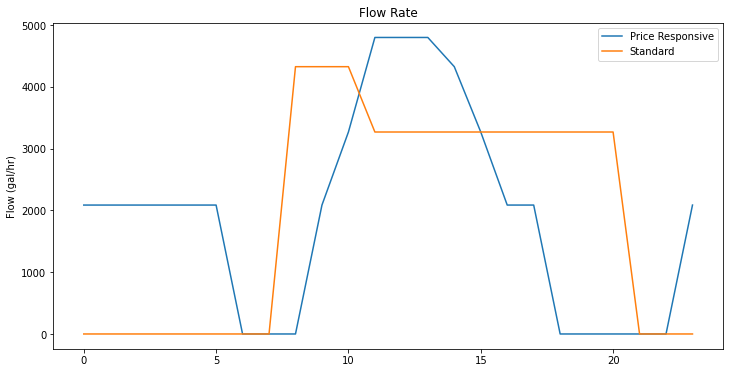

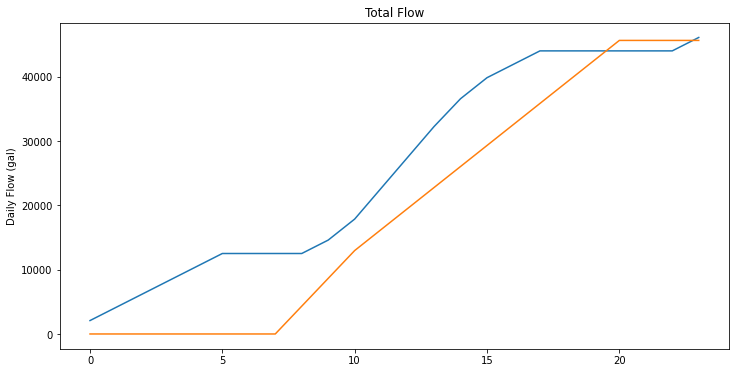

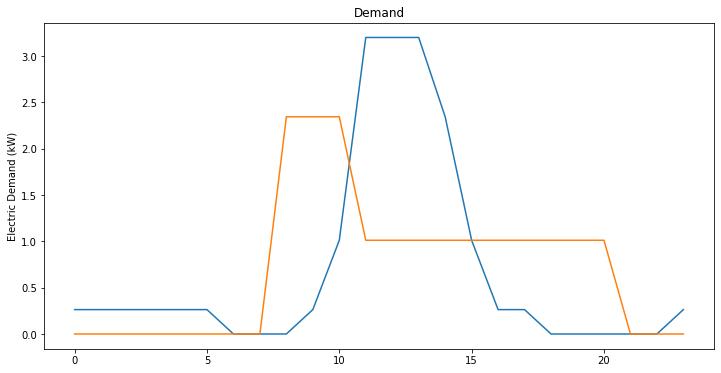

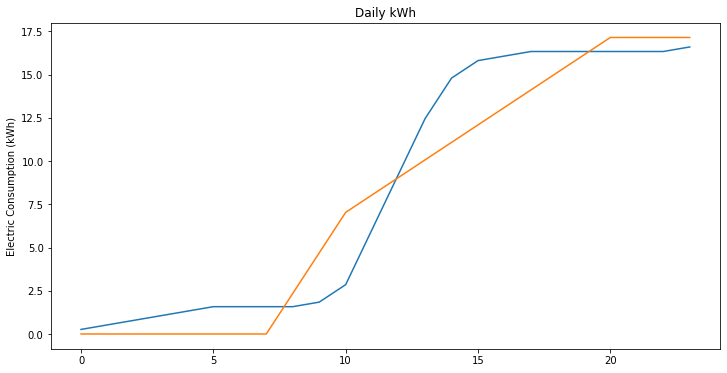

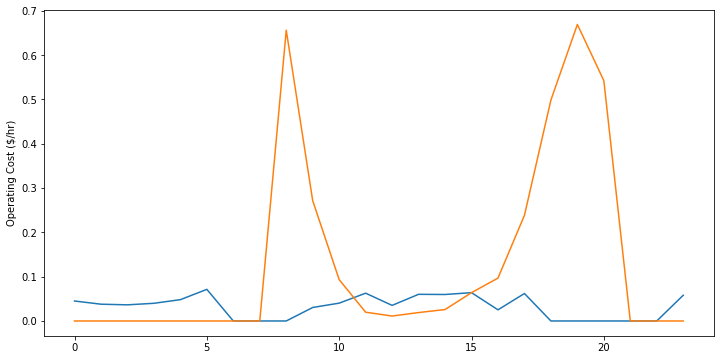

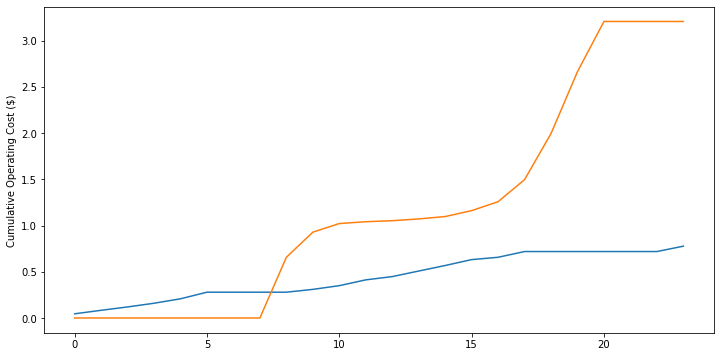

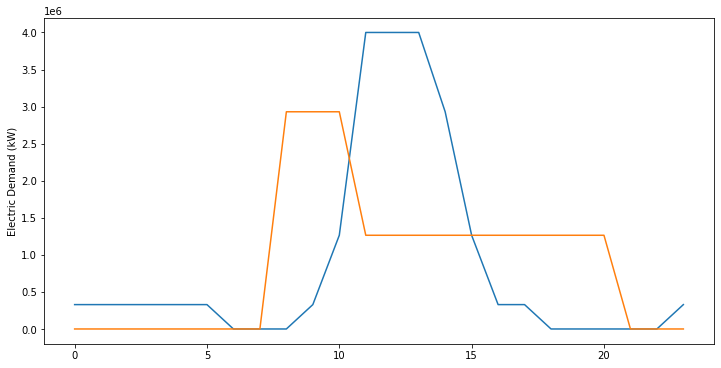

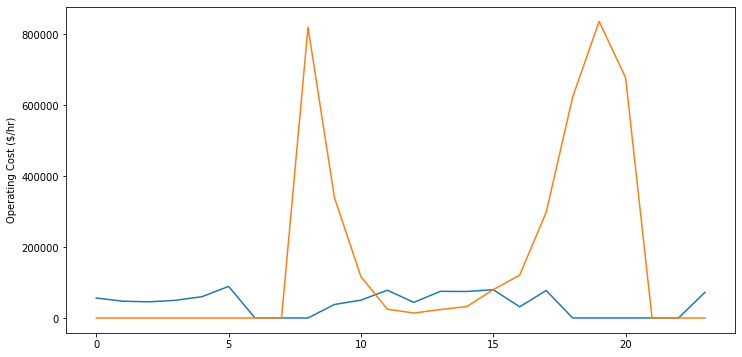

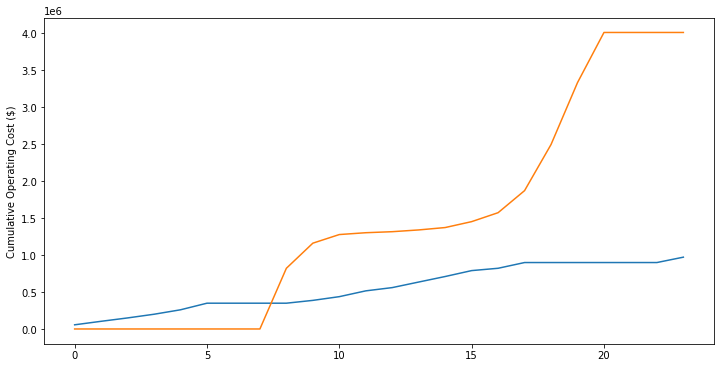

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Flow (gal)'], label = 'Price Responsive')
plt.plot(baseline_operation['Flow (gal)'], label = 'Standard')
plt.ylabel('Flow (gal/hr)')
plt.title('Flow Rate')
plt.legend()

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Flow (gal)'].cumsum(), label = 'Price Responsive')
plt.plot(baseline_operation['Flow (gal)'].cumsum(), label = 'Standard')
plt.ylabel('Daily Flow (gal)')
plt.title('Total Flow')

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Power (kW)'], label = 'Price Responsive')
plt.plot(baseline_operation['Power (kW)'], label = 'Standard')
plt.ylabel('Electric Demand (kW)')
plt.title('Demand')

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Power (kW)'].cumsum(), label = 'Price Responsive')
plt.plot(baseline_operation['Power (kW)'].cumsum(), label = 'Standard')
plt.ylabel('Electric Consumption (kWh)')
plt.title('Daily kWh')

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Cost ($)'], label = 'Price Responsive')
plt.plot(baseline_operation['Cost ($)'], label = 'Standard')
plt.ylabel('Operating Cost ($/hr)')

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Cost ($)'].cumsum(), label = 'Price Responsive')
plt.plot(baseline_operation['Cost ($)'].cumsum(), label = 'Standard')
plt.ylabel('Cumulative Operating Cost ($)')

# assumption: 1.25 million pools in CA. https://www.politico.com/newsletters/california-climate/2023/10/18/california-is-coming-for-your-pools-00122374#:~:text=There%20are%201.25%20million%20residential,because%20their%20pumps%20are%20bigger.
fleet_size = 1250000

# plotting impacts of entire fleet
fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Power (kW)'] * fleet_size, label = 'Price Responsive')
plt.plot(baseline_operation['Power (kW)'] * fleet_size, label = 'Standard')
plt.ylabel('Electric Demand (kW)')

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Cost ($)'] * fleet_size, label = 'Price Responsive')
plt.plot(baseline_operation['Cost ($)'] * fleet_size, label = 'Standard')
plt.ylabel('Operating Cost ($/hr)')

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Cost ($)'].cumsum() * fleet_size, label = 'Price Responsive')
plt.plot(baseline_operation['Cost ($)'].cumsum() * fleet_size, label = 'Standard')
plt.ylabel('Cumulative Operating Cost ($)')

print('fleet supervised_cost: {}'.format(supervised_cost * fleet_size))
print('fleet baseline_cost: {}'.format(baseline_cost * fleet_size))
print('fleet savings: {}'.format(savings * fleet_size))

In [8]:

# assume occpants want low noise, low flow rates overnight
low_flow_hours = [0, 1, 2, 3, 4, 5, 6, 22, 23]

# read prices
price_structure = 'TwoPeakHDP'
prices = pd.read_csv(r'C:\Users\btuser\Documents\Tools\HotWater\hpwhs\Input\Prices\CFH_Prices.csv', index_col = 0).loc[0:23, price_structure]

# creating baseline
# assumptions based on https://efficiencymb.ca/articles/programming-your-variable-speed-pool-pump/#:~:text=Scheduling%20your%20pump%20to%20run,1%2C500%20RPM%20and%202%2C000%20RPM.&text=You'll%20want%20to%20run,to%20four%20hours%20every%20day.
# assuming 3 hrs of high speed (Speed4), 20 hours of low speed (Speed2)
# assuming high speed in the middle of the day when people will be less irritated by noise
baseline_operation = pd.DataFrame(index = prices.index, columns = ['Mode', 'Flow (gal)', 'Power (kW)', 'Cost ($)'])
baseline_operation['Flow (gal)'] = float(0)
baseline_operation['Power (kW)'] = float(0)
baseline_operation['Cost ($)'] = float(0)
for hr in baseline_operation.index:
    if hr == 0 or hr == 1 or hr == 2 or hr == 3 or hr == 4 or hr == 5 or hr == 6 or hr == 7 or hr == 21 or hr == 22 or hr == 23:
        baseline_operation.loc[hr, 'Mode'] = 'Off'
        continue
    elif hr == 8 or hr == 9 or hr == 10:
        baseline_operation.loc[hr, 'Mode'] = 'LU'
    else:
        baseline_operation.loc[hr, 'Mode'] = 'Normal'
    
    # cost = prices.loc[hr] * modes['Speed3']['power (kW)']
    # baseline_operation.loc[hr, 'Mode'] = 'Normal'
    baseline_operation.loc[hr, 'Flow (gal)'] = modes[mode_map[baseline_operation.loc[hr, 'Mode']]]['flow (gal/min)'] * 60
    baseline_operation.loc[hr, 'Power (kW)'] = modes[mode_map[baseline_operation.loc[hr, 'Mode']]]['power (kW)']
    baseline_operation.loc[hr, 'Cost ($)'] = baseline_operation.loc[hr, 'Power (kW)'] * prices.loc[hr]

# Creating dataframe of all operation options
operation = pd.DataFrame(index = prices.index)
operation['Normal'] = prices * modes[mode_map['Normal']]['power (kW)'] / modes[mode_map['Normal']]['flow (gal/min)']
operation['LU'] = prices * modes[mode_map['LU']]['power (kW)'] / modes[mode_map['Normal']]['flow (gal/min)']
operation['ALU'] = prices * modes[mode_map['ALU']]['power (kW)' ] / modes[mode_map['Normal']]['flow (gal/min)']
operation['Shed'] = prices * modes[mode_map['Shed']]['power (kW)'] / modes[mode_map['Normal']]['flow (gal/min)']

# identify the daily pumping volume from the baseline pumping schedule
required_flow_vol = baseline_operation['Flow (gal)'].sum()

# create a list of operating costs for each hour/mode combintion, ranked from lowest to highest cost
operating_cost = pd.DataFrame(columns = ['Cost ($/gal)'])
# ix = []
for key in operation.columns:
    for val in operation.index:
        operating_cost.loc['{} - {}'.format(val, key), 'Cost ($/gal)'] = operation.loc[val, key]
        
operating_cost = operating_cost['Cost ($/gal)'].sort_values()
print(operating_cost)
# assumption: all pump modes are maintained for 1 hour. We may want to change that assumption

# identify the lowest cost operating schedule that meets the daily pumping volume
pumped_vol = 0
# create dataframe to show results
operation_times = pd.DataFrame(index = prices.index, columns = ['Mode', 'Flow (gal)', 'Power (kW)', 'Cost ($)'])
operation_times['Flow (gal)'] = float(0)
operation_times['Power (kW)'] = float(0)
operation_times['Cost ($)'] = float(0)
while operation_times['Flow (gal)'].sum() < required_flow_vol: # until we have identified adequate pumping
    operation_time = operating_cost.index[0].split(' - ')[0] # gather time of lowest cost operation
    operation_mode = operating_cost.index[0].split(' - ')[1] # gather mode of lowest cost operation
    if int(operation_time) in low_flow_hours: # avoid operation choices that conflict with user-specified "quiet operation" times
        if operation_mode != 'Shed':
            operating_cost.drop(operating_cost.index[0], inplace = True)
            continue
    # identify the impacts of the cheapest operating mode
    flow_vol = modes[mode_map[operation_mode]]['flow (gal/min)'] * 60
    operation_times.loc[int(operation_time), 'Mode'] = operation_mode
    operation_times.loc[int(operation_time), 'Flow (gal)'] = flow_vol
    operation_times.loc[int(operation_time), 'Power (kW)'] = modes[mode_map[operation_mode]]['power (kW)']
    operation_times.loc[int(operation_time), 'Cost ($)'] = operation_times.loc[int(operation_time), 'Power (kW)'] * prices.loc[int(operation_time)]
    
    # remove that operating mode from the list, moving to the next cheapest option in the next iteration
    operating_cost.drop(operating_cost.index[0], inplace = True)

supervised_cost = operation_times['Cost ($)'].sum()
baseline_cost = baseline_operation['Cost ($)'].sum()
savings = baseline_cost - supervised_cost
savings_percent = savings / baseline_cost * 100
print('supervised_cost: {}'.format(supervised_cost))
print('baseline_cost: {}'.format(baseline_cost))
print('savings: {}'.format(savings))
print('savings_percent: {}'.format(savings_percent))

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Flow (gal)'], label = 'Price Responsive')
plt.plot(baseline_operation['Flow (gal)'], label = 'Standard')
plt.ylabel('Flow (gal/hr)')
plt.title('Flow Rate')

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Flow (gal)'].cumsum(), label = 'Price Responsive')
plt.plot(baseline_operation['Flow (gal)'].cumsum(), label = 'Standard')
plt.ylabel('Daily Flow (gal)')
plt.title('Total Flow')

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Power (kW)'], label = 'Price Responsive')
plt.plot(baseline_operation['Power (kW)'], label = 'Standard')
plt.ylabel('Electric Demand (kW)')
plt.title('Demand')

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Power (kW)'].cumsum(), label = 'Price Responsive')
plt.plot(baseline_operation['Power (kW)'].cumsum(), label = 'Standard')
plt.ylabel('Electric Consumption (kWh)')
plt.title('Daily kWh')

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Cost ($)'], label = 'Price Responsive')
plt.plot(baseline_operation['Cost ($)'], label = 'Standard')
plt.ylabel('Operating Cost ($/hr)')

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Cost ($)'].cumsum(), label = 'Price Responsive')
plt.plot(baseline_operation['Cost ($)'].cumsum(), label = 'Standard')
plt.ylabel('Cumulative Operating Cost ($)')

# assumption: 1.25 million pools in CA. https://www.politico.com/newsletters/california-climate/2023/10/18/california-is-coming-for-your-pools-00122374#:~:text=There%20are%201.25%20million%20residential,because%20their%20pumps%20are%20bigger.
fleet_size = 1250000

# plotting impacts of entire fleet
fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Power (kW)'] * fleet_size, label = 'Price Responsive')
plt.plot(baseline_operation['Power (kW)'] * fleet_size, label = 'Standard')
plt.ylabel('Electric Demand (kW)')

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Cost ($)'] * fleet_size, label = 'Price Responsive')
plt.plot(baseline_operation['Cost ($)'] * fleet_size, label = 'Standard')
plt.ylabel('Operating Cost ($/hr)')

fig = plt.figure(figsize = (12, 6))
plt.plot(operation_times['Cost ($)'].cumsum() * fleet_size, label = 'Price Responsive')
plt.plot(baseline_operation['Cost ($)'].cumsum() * fleet_size, label = 'Standard')
plt.ylabel('Cumulative Operating Cost ($)')

print('fleet supervised_cost: {}'.format(supervised_cost * fleet_size))
print('fleet baseline_cost: {}'.format(baseline_cost * fleet_size))
print('fleet savings: {}'.format(savings * fleet_size))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\btuser\\Documents\\Tools\\HotWater\\hpwhs\\Input\\Prices\\CFH_Prices.csv'

In [ ]:
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'Tools', 'References'))

from LBL_Presentation_Colors import Colors

fig, ax = plt.subplots(figsize = (6, 2))
ln1 = ax.plot(operation['Normal'], label = 'Normal', color = Colors['Dark_Teal'], linestyle = 'dashed')
ln2 = ax.plot(operation['LU'], label = 'Load up', color = Colors['Lab_Blue'], linestyle = 'dashed')
ln3 = ax.plot(operation['ALU'], label = 'Advanced', color = Colors['Green'], linestyle = 'dashed')
ln4 = ax.plot(operation['Shed'], label = 'Shed', color = Colors['Aqua'], linestyle = 'dashed')
# ax.legend()
ax.set_xlabel('Time of Day (hr)')
ax.set_ylabel('Operating Cost ($/gal)')

ax2 = ax.twinx()
ln5 = ax2.plot(operation_times['Power (kW)'], color = Colors['Red'], linewidth = 2, label = 'Power')
ax2.set_ylabel('Operating Power (kW)')

lns = ln1+ln2+ln3+ln4+ln5
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc = 'upper left')

In [ ]:
prices.plot.bar(width = 1, alpha = 0.5, color = Colors['Red'])

In [ ]:
import numpy as np
average = prices.mean()
high = np.percentile(prices, 80)
low = np.percentile(prices, 50)
print(average)
print(high)
print(low)

In [ ]:
fig, ax = plt.subplots(figsize = (6, 2))
ln1 = ax.plot(operation['Normal'], label = 'Normal', color = Colors['Dark_Teal'], linestyle = 'dashed')
ln2 = ax.plot(operation['LU'], label = 'Load up', color = Colors['Lab_Blue'], linestyle = 'dashed')
ln3 = ax.plot(operation['ALU'], label = 'Advanced', color = Colors['Green'], linestyle = 'dashed')
ln4 = ax.plot(operation['Shed'], label = 'Shed', color = Colors['Aqua'], linestyle = 'dashed')
ax.legend(loc = 'upper left')
ax.set_xlabel('Time of Day (hr)')
ax.set_ylabel('Operating Cost ($/gal)')

operation_times_plot = operation_times.copy(deep = True)
for row in operation_times_plot.index:
    mode = operation_times_plot.loc[row, 'Mode']
    if mode == 'Shed':
        operation_times_plot.loc[row, 'Mode'] = 1
    elif mode == 'Normal':
        operation_times_plot.loc[row, 'Mode'] = 2
    elif mode == 'LU':
        operation_times_plot.loc[row, 'Mode'] = 3
    elif mode == 'ALU':
        operation_times_plot.loc[row, 'Mode'] = 4
    else:
        operation_times_plot.loc[row, 'Mode'] = 0

ax2 = ax.twinx()        
# fig = plt.figure(figsize = (12, 6))

barlist = ax2.bar(x = operation_times_plot.index, height = operation_times_plot['Mode'], width = 1, alpha = 0.5, 
                  color = Colors['Red'], edgecolor = 'none')
ax2.legend()
locations = [0, 1, 2, 3, 4]
labels = ['Off', 'Shed', 'Normal', 'Load Up', 'Advanced Load Up']
ax2.set_yticks(locations, labels)

# for row in operation_times_plot.index:
#     mode = operation_times_plot.loc[row, 'Mode']
#     if mode == 0:
#         barlist[row].set_color(Colors['Main_White'])
#         barlist[row].set_edgecolor('none')   
#     elif mode == 1:
#         barlist[row].set_color(Colors['Aqua'])
#         barlist[row].set_edgecolor('none')   
#     elif mode == 2:
#         barlist[row].set_color(Colors['Dark_Teal'])
#         barlist[row].set_edgecolor('none')   
#     elif mode == 3:
#         barlist[row].set_color(Colors['Lab_Blue'])        
#         barlist[row].set_edgecolor('none')   
#     elif mode == 4:
#         barlist[row].set_color(Colors['Green'])   
#         barlist[row].set_edgecolor('none')   



In [ ]:
print(Colors)